In [1]:
import torch
from torch import nn

import torch.functional as F

from PIL import Image
import torchvision.transforms.functional as TF

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import numpy as np
import random

import requests
import io

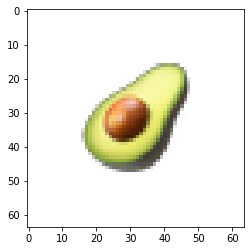

In [2]:
def load_image(url, max_size=32, padding=16):
    r = requests.get(url)
    img = Image.open(io.BytesIO(r.content))
    img.thumbnail((max_size, max_size), Image.ANTIALIAS)
    img = np.float32(img)/255.0
    img = np.pad(img,((padding,padding),(padding,padding),(0,0)))
    
    img[..., :3] *= img[..., 3:]
    
    img = torch.Tensor(img).float().cuda()
    img = img.transpose(0,2)

    return img


def load_emoji(emoji):
    code = hex(ord(emoji))[2:].lower()
    url = 'https://raw.githubusercontent.com/iamcal/emoji-data/master/img-apple-64/%s.png' % code
    return load_image(url)


image = load_emoji("🥑")

plt.imshow(image.transpose(0,2).cpu())

img_size = 64

In [3]:
class Automata(nn.Module):

    def __init__(self, grid_size, n_channels):

        super(Automata, self).__init__()

        self.n_channels = n_channels
        self.grid_size = grid_size

        self.filters = torch.Tensor([[[[-1, 0, 1],
                                       [-2, 0, 2],
                                       [-1, 0, 1]
                                       ]],
                                     [[[-1, -2, -1],
                                       [0, 0, 0],
                                       [1, 2, 1]
                                       ]],
                                     [[[0, 0, 0],
                                       [0, 1, 0],
                                       [0, 0, 0]
                                       ]]]).cuda()

        self.mapper = nn.Sequential(
            nn.Linear(3*n_channels, 128),
            nn.ReLU(),
            nn.Linear(128, n_channels),
            nn.Tanh()
        )

        self.mapper[2].weight.data.fill_(0)
        self.mapper[2].bias.data.fill_(0)

    def perception(self, x):

        # reshape for same convolution across channels
        x = x.reshape(-1, 1, self.grid_size[0], self.grid_size[1])

        # toroidal padding
        conved = nn.functional.pad(x, (1, 1, 1, 1), mode="reflect")

        conved = nn.functional.conv2d(conved, model.filters)

        # reshape for perception computations
        conved = conved.view(self.batch_size, 3*self.n_channels, -1)
        conved = conved.transpose(1, 2)

        conved = self.mapper(conved)

        conved = conved.transpose(1, 2)
        # (batch_size, channels, total_cells)

        conved = conved.view(self.batch_size, self.n_channels, *self.grid_size)

        can_update = torch.rand_like(conved) < 0.75

        return conved*can_update

    def forward(self, x, iterations, keep_history=False):

        if keep_history:

            model.history = torch.zeros(iterations, *x.shape)

        model.batch_size = x.shape[0]

        for i in range(iterations):

            conved = self.perception(x)

            x = x + conved

            is_alive = nn.functional.max_pool2d(
                x[:, 3], (3, 3), stride=1, padding=1) > 0.1

            is_alive = is_alive[:, None]

            x = x*is_alive

            x[:, :4].clamp_(0, 1)

            if keep_history:

                model.history[i] = x

        return x

In [4]:
n_channels = 16
n_epochs = 2500
lr = 0.001
pool_size = 1024
batch_size = 8

model = Automata((64, 64), n_channels).cuda()

# initialize pool with seeds
seed = torch.zeros(n_channels,img_size,img_size).cuda()
seed[3:,32,32] = 1

pool_initials = seed[None, :].repeat(pool_size,1,1,1)
pool_targets = image[None,:].repeat(pool_size,1,1,1)

losses = []

criterion = nn.MSELoss(reduction='none')
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

for i in range(n_epochs):
    
    iterations = random.randint(64,96)
    
#     initial_state = torch.rand(n_channels, 1, 32, 32).cuda()
#     initial_state = initial_state < 0.01
#     initial_state = initial_state.float()
#     initial_state = nn.functional.pad(initial_state,(16,16,16,16))

    pool_indices = random.sample(range(pool_size),batch_size)
        
    initial_states = pool_initials[pool_indices]
    
    targets = pool_targets[pool_indices]


#     initial_state = torch.zeros(1,n_channels, 64, 64).cuda()
#     initial_state[0,3:,32,32] = 1

    out = model(initial_states,iterations)
    
    phenotypes = out[:,:4].squeeze()

    optimizer.zero_grad()

    loss = criterion(phenotypes, targets)
    
    per_sample_loss = loss.mean((1,2,3))
    total_loss = per_sample_loss.mean()

    total_loss.backward()
    optimizer.step()
    
    # re-insert back to the pool
    
#     if i > 100:
    max_loss_idx = per_sample_loss.argmax()
    
    replacements = out.detach()
    replacements[max_loss_idx] = seed.clone()

    pool_initials[pool_indices] = replacements

    if i % 10 == 0:
    
        print(i, float(total_loss.cpu().detach()))
        
    losses.append(float(total_loss))

0 0.08465249091386795
10 0.07735424488782883
20 0.017997775226831436
30 0.03801991418004036
40 0.019202258437871933
50 0.03944627195596695
60 0.052522607147693634
70 0.031548261642456055
80 0.022883281111717224
90 0.034917496144771576
100 0.049887023866176605
110 0.027048416435718536
120 0.06011902913451195
130 0.0344524048268795
140 0.01956457644701004
150 0.025086531415581703
160 0.036900296807289124
170 0.025464648380875587
180 0.03171857073903084
190 0.022006774321198463
200 0.03065432794392109
210 0.03401269391179085
220 0.03367440775036812
230 0.023553255945444107
240 0.018686443567276
250 0.021917007863521576
260 0.026219144463539124
270 0.02076035551726818
280 0.024866655468940735
290 0.023233162239193916
300 0.034457482397556305
310 0.03863289952278137
320 0.03369283676147461
330 0.034962765872478485
340 0.026455610990524292
350 0.025046464055776596
360 0.02115625888109207
370 0.02627374604344368
380 0.024586493149399757
390 0.05032896250486374
400 0.024652814492583275
410 0.0

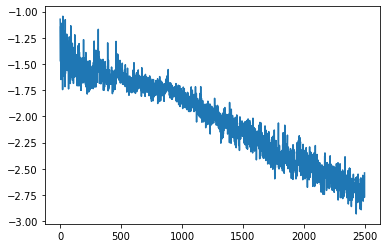

In [5]:
plt.plot(np.log10(losses))

In [6]:
pool_indices

[40, 762, 231, 716, 34, 589, 157, 79]

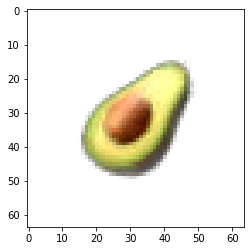

In [8]:
plt.imshow(pool_initials[589,:4].transpose(0,2).cpu())

In [9]:
out = model(seed[None,:],256,keep_history=True).squeeze()

In [10]:
video = model.history.cpu().detach()
video = video[:,0,:4]
video = video.transpose(1,3)

In [11]:
from matplotlib import animation
from IPython.display import HTML

fig = plt.figure()
im = plt.imshow(video[0,:,:,:])

plt.close()

def init():
    im.set_data(video[0,:,:,:])

def animate(i):
    im.set_data(video[i,:,:,:])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init,  frames=video.shape[0],
                               interval=50)
HTML(anim.to_html5_video())